# Processing and narrating a video with GPT-4o's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4o doesn't take videos as input directly, but we can use vision and the 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4o to get a description of a video
2. Generating a voiceover for a video with GPT-o and the TTS API


In [16]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "sk-proj-f9SndZYGA9903yPgSv4XT3BlbkFJea5zsT7Z8v1mglV8N9yA"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [17]:
video = cv2.VideoCapture("AD001.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

305 frames read.


Display frames to make sure we've read them in correctly:


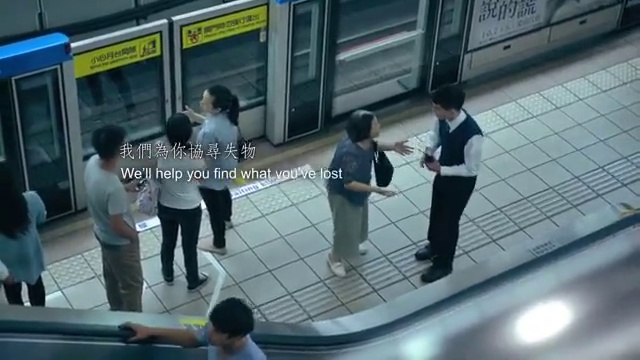

KeyboardInterrupt: 

In [10]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [18]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-turbo",
    "messages": PROMPT_MESSAGES,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Title: "A Race Against Time: The Search for Little Wade"

Description:
Immerse yourself in the urgency and emotion of a grandmother's quest through the crowded heart of the city's subway in our latest video. In "A Race Against Time: The Search for Little Wade," witness the heartfelt scenes as an elderly woman navigates the bustling chaos of commuters, desperate to find her lost grandson. From anxious strides across platform tiles to earnest interactions with strangers, each frame captures the poignant blend of hope and worry on her journey. Will she find Little Wade amidst the urban rush? Join us in this gripping narrative that goes beyond the surface and touches the core of familial bonds and societal kindness. Stream the full video to unravel the conclusion of this touching urban tale.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [42]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "這些是影片的幀。創建一個簡短的口述影像腳本。僅包含50字旁白，儘量貼近原作品再現的原則。無須描述對話。",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

人潮匆忙地穿梭在地鐵站，一位婦人焦急地在人群中尋找著她的小孩，不停向路人詢問，地鐵車門即將關閉。


Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [33]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer sk-proj-f9SndZYGA9903yPgSv4XT3BlbkFJea5zsT7Z8v1mglV8N9yA",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "nova",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)